C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\keras_preprocessing\image\affine_transformations.py:13: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  import scipy


Epoch 1/150
3/3 [==============================] - 27s 827ms/step - loss: 0.1183 - val_loss: 0.0928
Epoch 2/150
3/3 [==============================] - 0s 162ms/step - loss: 0.1005 - val_loss: 0.0658
Epoch 3/150
3/3 [==============================] - 0s 187ms/step - loss: 0.0649 - val_loss: 0.0338
Epoch 4/150
3/3 [==============================] - 0s 172ms/step - loss: 0.0512 - val_loss: 0.0233
Epoch 5/150
3/3 [==============================] - 0s 97ms/step - loss: 0.0492 - val_loss: 0.0214
Epoch 6/150
3/3 [==============================] - 0s 108ms/step - loss: 0.0427 - val_loss: 0.0259
Epoch 7/150
3/3 [==============================] - 0s 137ms/step - loss: 0.0421 - val_loss: 0.0238
Epoch 8/150
3/3 [==============================] - 0s 163ms/step - loss: 0.0396 - val_loss: 0.0287
Epoch 9/150
3/3 [==============================] - 0s 166ms/step - loss: 0.0378 - val_loss: 0.0190
Epoch 10/150
3/3 [==============================] - 0s 110ms/step - loss: 0.0377 - val_loss: 0.0214
Epoch 11/

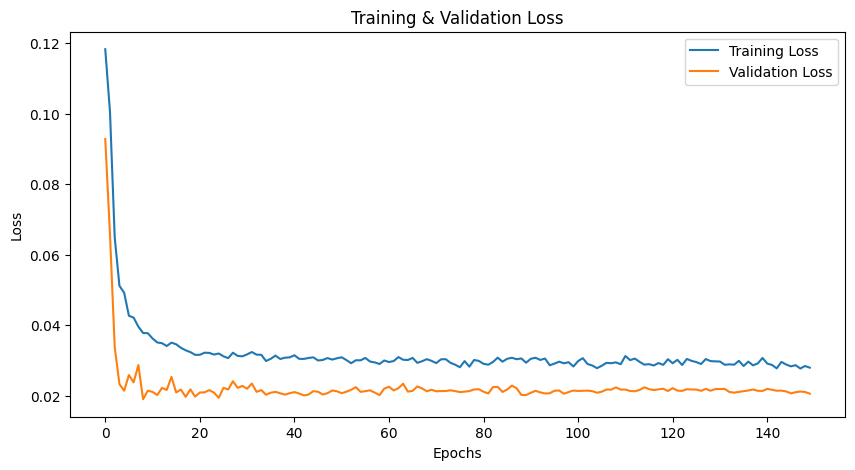

C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0, flags=flags)


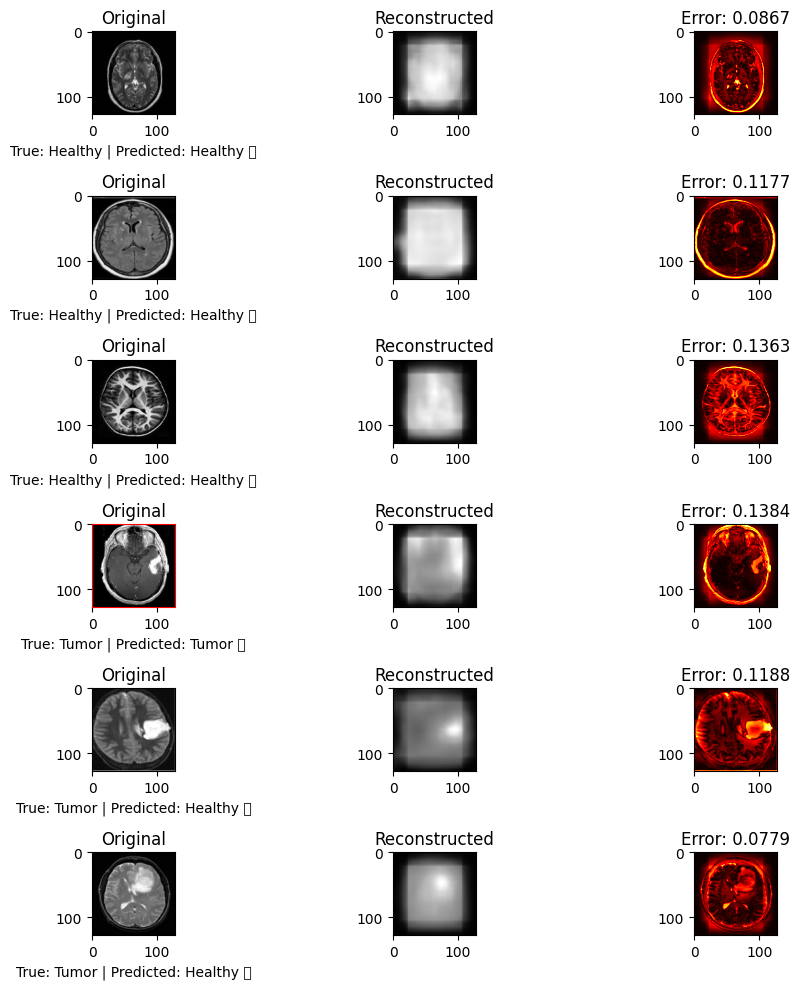

Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\35 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.0867
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\31 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1177
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\14 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1363
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y55.jpg | True: Tumor | Predicted: Tumor ✅ | Error: 0.1384
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y97.JPG | True: Tumor | Predicted: Healthy ❌ | Error: 0.1188
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y66.JPG | True: Tumor | Predicted: Healthy ❌ | Error: 0.0779


In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# **Step 1: Load Dataset (Only Healthy Images for Training)**
data_dir = "C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset"  # Update path
img_size = 128

healthy_data = []
for img_name in os.listdir(os.path.join(data_dir, "no")):
    try:
        img_path = os.path.join(data_dir, "no", img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        healthy_data.append(img)
    except Exception as e:
        print(f"Error loading image: {img_name} - {e}")

healthy_data = np.array(healthy_data) / 255.0
healthy_data = np.expand_dims(healthy_data, axis=-1)

# Train-test split
X_train, X_val = train_test_split(healthy_data, test_size=0.2, random_state=42)

# **Step 2: Data Augmentation**
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# **Step 3: Autoencoder Model**
input_img = Input(shape=(img_size, img_size, 1))

# Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# **Step 4: Train Autoencoder**
history = autoencoder.fit(
    datagen.flow(X_train, X_train, batch_size=32),
    epochs=150,  # Increased to 150
    batch_size=32,
    validation_data=(X_val, X_val)
)

# **Step 5: Plot Accuracy Graphs**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show(block=True) 

# **Step 6: Compute Reconstruction Error**
def compute_reconstruction_error(model, images):
    reconstructed = model.predict(images)
    errors = np.mean(np.abs(images - reconstructed), axis=(1, 2, 3))
    return reconstructed, errors

# **Step 7: Validate on Random Images from Yes & No Categories**
test_images, test_labels, test_paths = [], [], []

for category in ["no", "yes"]:
    path = os.path.join(data_dir, category)
    for img_name in np.random.choice(os.listdir(path), 3, replace=False):  # Random 3 images
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            test_images.append(img)
            test_labels.append(0 if category == "no" else 1)  # 0: Healthy, 1: Tumor
            test_paths.append(img_path)
        except:
            continue

test_images = np.array(test_images) / 255.0
test_images = np.expand_dims(test_images, axis=-1)

# **Step 8: Compute Reconstruction Error**
reconstructed_images, errors = compute_reconstruction_error(autoencoder, test_images)
threshold = np.percentile(errors, 90)  # 90th percentile threshold

# **Step 9: Display Results**
fig, axes = plt.subplots(len(test_images), 3, figsize=(10, 10))

for i in range(len(test_images)):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap="gray")
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(reconstructed_images[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Reconstructed")

    axes[i, 2].imshow(np.abs(test_images[i] - reconstructed_images[i]).squeeze(), cmap="hot")
    axes[i, 2].set_title(f"Error: {errors[i]:.4f}")

    # **Tumor Detection Logic**
    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"

    # Display Labels
    axes[i, 0].set_xlabel(f"True: {true_label} | Predicted: {detected_label} {correct}")
    
    # Highlight Tumor if detected
    if detected_label == "Tumor":
        axes[i, 0].spines["bottom"].set_color("red")
        axes[i, 0].spines["top"].set_color("red")
        axes[i, 0].spines["left"].set_color("red")
        axes[i, 0].spines["right"].set_color("red")

plt.tight_layout()
plt.show()

# **Step 10: Print Errors & Detection Results**
for i in range(len(test_images)):
    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"
    print(f"Image: {test_paths[i]} | True: {true_label} | Predicted: {detected_label} {correct} | Error: {errors[i]:.4f}")


Epoch 1/50
5/5 [==============================] - 33s 6s/step - loss: 0.1685 - val_loss: 0.1377
Epoch 2/50
5/5 [==============================] - 33s 7s/step - loss: 0.1459 - val_loss: 0.1136
Epoch 3/50
5/5 [==============================] - 33s 7s/step - loss: 0.1281 - val_loss: 0.0919
Epoch 4/50
5/5 [==============================] - 34s 7s/step - loss: 0.1159 - val_loss: 0.0786
Epoch 5/50
5/5 [==============================] - 31s 7s/step - loss: 0.1015 - val_loss: 0.0621
Epoch 6/50
5/5 [==============================] - 33s 7s/step - loss: 0.0940 - val_loss: 0.0534
Epoch 7/50
5/5 [==============================] - 32s 6s/step - loss: 0.0889 - val_loss: 0.0495
Epoch 8/50
5/5 [==============================] - 32s 7s/step - loss: 0.0842 - val_loss: 0.0454
Epoch 9/50
5/5 [==============================] - 31s 6s/step - loss: 0.0795 - val_loss: 0.0438
Epoch 10/50
5/5 [==============================] - 32s 6s/step - loss: 0.0795 - val_loss: 0.0436
Epoch 11/50
5/5 [======================

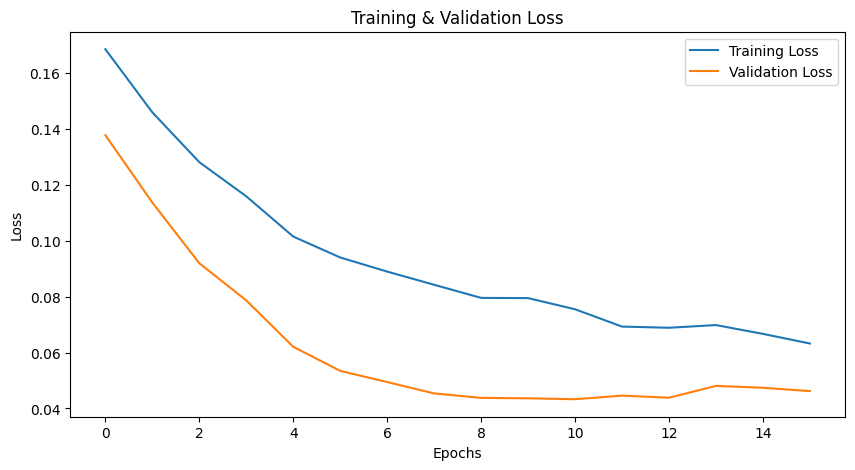

C:\Users\boorl\.conda\envs\convAE2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\.conda\envs\convAE2\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\.conda\envs\convAE2\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\boorl\.conda\envs\convAE2\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0, flags=flags)


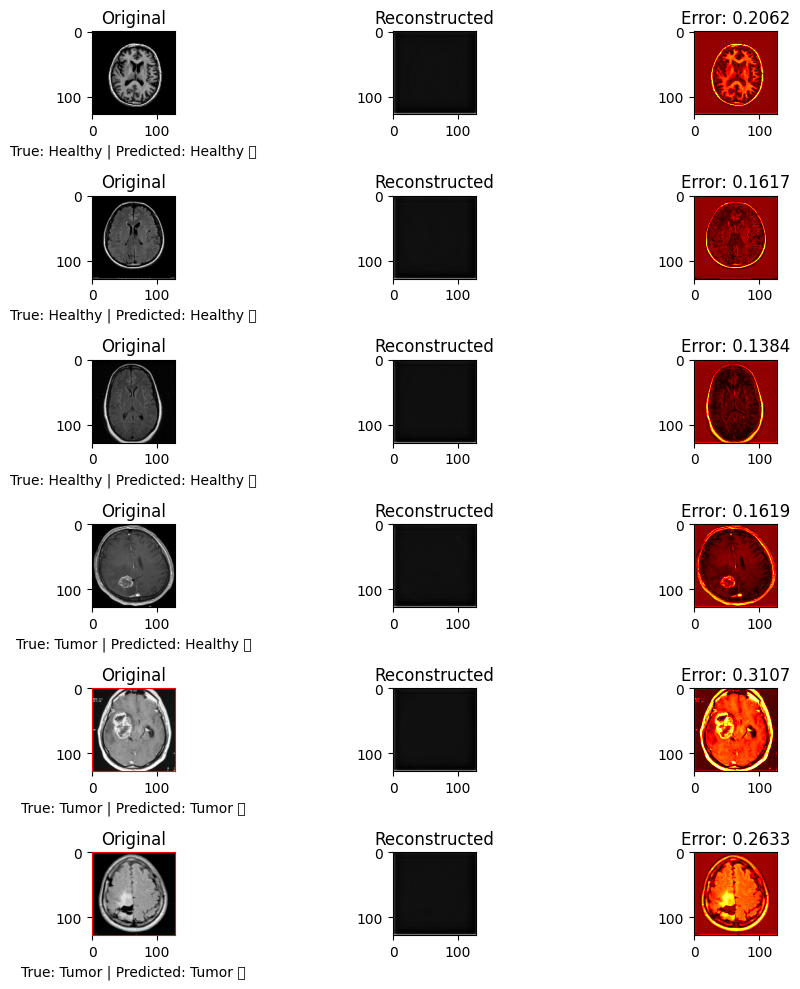

Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\no\37 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.2062
Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\no\5 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1617
Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\no\No20.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1384
Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\yes\Y54.jpg | True: Tumor | Predicted: Healthy ❌ | Error: 0.1619
Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\yes\Y14.jpg | True: Tumor | Predicted: Tumor ✅ | Error: 0.3107
Image: C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset\yes\Y168.jpg | True: Tumor | Predicted: Tumor ✅ | Error: 0.2633


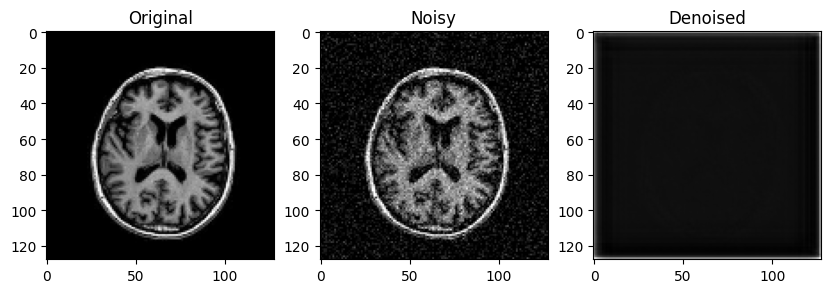

In [3]:
#old code but with 20 epochs and 8 batch_size and 5 patience
#filters - 64 , 128 , 256 

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# **Step 1: Load Dataset (Healthy and Tumor Images for Training)**
data_dir = "C://Users//YourUsername//anaconda3//envs//convAE//brain_tumor_dataset"
 # Update path
img_size = 128

healthy_data, tumor_data = [], []
for category in ["no", "yes"]:
    for img_name in os.listdir(os.path.join(data_dir, category)):
        try:
            img_path = os.path.join(data_dir, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            if category == "no":
                healthy_data.append(img)
            else:
                tumor_data.append(img)
        except Exception as e:
            print(f"Error loading image: {img_name} - {e}")

# Normalize data
healthy_data = np.array(healthy_data) / 255.0
tumor_data = np.array(tumor_data) / 255.0

# Add channel dimension
healthy_data = np.expand_dims(healthy_data, axis=-1)
tumor_data = np.expand_dims(tumor_data, axis=-1)

# **Step 2: Add Gaussian Noise for Denoising**
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0, 1)

noisy_healthy_data = add_gaussian_noise(healthy_data)

# Train-test split for healthy data
X_train, X_val = train_test_split(noisy_healthy_data, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(healthy_data, test_size=0.2, random_state=42)

# **Step 3: Enhanced Data Augmentation**
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
datagen.fit(X_train)

# **Step 4: Enhanced Autoencoder Model with Skip Connections**
input_img = Input(shape=(img_size, img_size, 1))

# Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
enc1 = x
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding="same")(x)
enc2 = x
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(256, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Concatenate()([x, enc2])
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Concatenate()([x, enc1])
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")

# **Step 5: Train Autoencoder with Callbacks**
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

# **Step 6: Plot Training & Validation Loss**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Step 7: Compute Reconstruction Error**
def compute_reconstruction_error(model, images):
    reconstructed = model.predict(images)
    errors = np.mean(np.abs(images - reconstructed), axis=(1, 2, 3))
    return reconstructed, errors

# **Step 8: Validate on Random Images from Yes & No Categories**
test_images, test_labels, test_paths = [], [], []
for category in ["no", "yes"]:
    path = os.path.join(data_dir, category)
    for img_name in np.random.choice(os.listdir(path), 3, replace=False):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            test_images.append(img)
            test_labels.append(0 if category == "no" else 1)
            test_paths.append(img_path)
        except:
            continue

test_images = np.array(test_images) / 255.0
test_images = np.expand_dims(test_images, axis=-1)

# **Step 9: Compute Reconstruction Error and Dynamic Threshold**
reconstructed_images, errors = compute_reconstruction_error(autoencoder, test_images)

# Dynamic threshold: mean + 2*std of errors on healthy validation data
healthy_val_reconstructed, healthy_val_errors = compute_reconstruction_error(autoencoder, X_val)
threshold = np.mean(healthy_val_errors) + 2 * np.std(healthy_val_errors)

# **Step 10: Display Results**
fig, axes = plt.subplots(len(test_images), 3, figsize=(10, 10))
for i in range(len(test_images)):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap="gray")
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(reconstructed_images[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Reconstructed")

    axes[i, 2].imshow(np.abs(test_images[i] - reconstructed_images[i]).squeeze(), cmap="hot")
    axes[i, 2].set_title(f"Error: {errors[i]:.4f}")

    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"

    axes[i, 0].set_xlabel(f"True: {true_label} | Predicted: {detected_label} {correct}")

    if detected_label == "Tumor":
        axes[i, 0].spines["bottom"].set_color("red")
        axes[i, 0].spines["top"].set_color("red")
        axes[i, 0].spines["left"].set_color("red")
        axes[i, 0].spines["right"].set_color("red")

plt.tight_layout()
plt.show()

# **Step 11: Print Errors & Detection Results**
for i in range(len(test_images)):
    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"
    print(f"Image: {test_paths[i]} | True: {true_label} | Predicted: {detected_label} {correct} | Error: {errors[i]:.4f}")

# **Step 12: Denoising Example**
# Add noise to a healthy image
noise_factor = 0.1
noisy_test_image = test_images[0] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images[0].shape)
noisy_test_image = np.clip(noisy_test_image, 0., 1.)

# Denoise using the autoencoder
denoised_image = autoencoder.predict(np.expand_dims(noisy_test_image, axis=0)).squeeze()

# Display denoising result
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(test_images[0].squeeze(), cmap="gray")
plt.title("Original")
plt.subplot(132)
plt.imshow(noisy_test_image.squeeze(), cmap="gray")
plt.title("Noisy")
plt.subplot(133)
plt.imshow(denoised_image, cmap="gray")
plt.title("Denoised")
plt.show()